# CITE-seq TotalVi processing

In [1]:
!date
!hostname

Wed Jul 10 10:19:31 PDT 2024
c4-gpudev1


In [2]:
%env CONDA_PREFIX

'/c4/home/derek/miniconda3/envs/SCVI'

In [3]:
import tempfile

import anndata as ad
import matplotlib.pyplot as plt
import mudata as md
#import muon
import scanpy as sc
import scvi
import seaborn as sns
import torch

/c4/home/derek/miniconda3/envs/SCVI/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [41]:
scvi.settings.seed = 1

Seed set to 1


In [4]:
torch.cuda.is_available()

True

In [5]:
input_dir = '/c4/home/derek/data1/derek/data_scSLR/PBMC/'

In [6]:
adata = sc.read_h5ad(input_dir+'10X/geo_H5/concat.3.new.raw.h5ad')

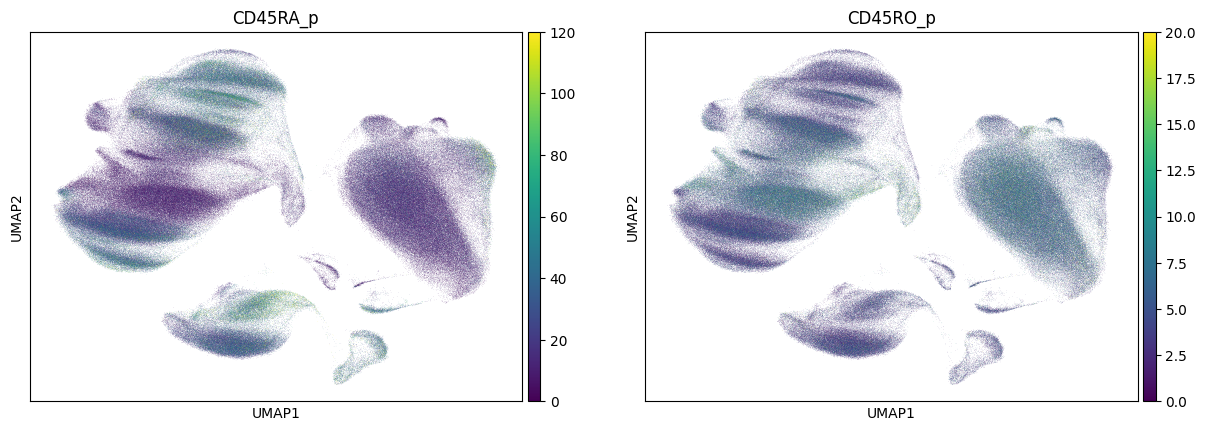

In [7]:
sc.pl.umap(adata,
           color=['CD45RA_p','CD45RO_p'],
           vmax='p99'
          )

In [8]:
# add cite-seq data to obsm
adata.obsm['protein_expression'] = adata.to_df()[[i for i in adata.var_names if i.endswith('_p')]]

In [9]:
# remove cite-seq from main matrix 
adata = adata[:,adata.var.feature_types != 'Antibody Capture']

In [10]:
adata.layers["counts"] = adata.X.copy()
sc.pp.normalize_total(adata)
sc.pp.log1p(adata)
adata.obs_names_make_unique()

/scratch/derek/ipykernel_2972457/2264831421.py:1: ImplicitModificationWarning: Setting element `.layers['counts']` of view, initializing view as actual.
  adata.layers["counts"] = adata.X.copy()


In [11]:
sc.pp.highly_variable_genes(
    adata,
    n_top_genes=4000,
    flavor="seurat_v3",
    batch_key="batch",
    subset=True,
    layer="counts"
)

In [12]:
adata=adata[adata.obs.batch.isin(['22','23'])]

In [13]:
adata = adata.copy()

In [14]:
scvi.model.TOTALVI.setup_anndata(
    adata,
    protein_expression_obsm_key="protein_expression",
    layer="counts",
    batch_key="batch"
)

CUDA backend failed to initialize: Unable to use CUDA because of the following issues with CUDA components:
Outdated cuSPARSE installation found.
Version JAX was built against: 12200
Minimum supported: 12100
Installed version: 12002
The local installation version must be no lower than 12100..(Set TF_CPP_MIN_LOG_LEVEL=0 and rerun for more info.)


INFO     Using column names from columns of adata.obsm['protein_expression']                                       


/c4/home/derek/miniconda3/envs/SCVI/lib/python3.9/site-packages/scvi/data/fields/_layer_field.py:115: UserWarning: Training will be faster when sparse matrix is formatted as CSR. It is safe to cast before model initialization.
  _verify_and_correct_data_format(adata, self.attr_name, self.attr_key)


In [15]:
%%time
vae = scvi.model.TOTALVI(adata, latent_distribution="normal")


INFO     Computing empirical prior initialization for protein background.                                          
CPU times: user 44 s, sys: 30.7 ms, total: 44 s
Wall time: 1.06 s


In [16]:
%%time
vae.train()


/c4/home/derek/miniconda3/envs/SCVI/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /c4/home/derek/miniconda3/envs/SCVI/lib/python3.9/si ...
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
IPU available: False, using: 0 IPUs
HPU available: False, using: 0 HPUs
/c4/home/derek/miniconda3/envs/SCVI/lib/python3.9/site-packages/lightning/fabric/plugins/environments/slurm.py:191: The `srun` command is available on your system but is not used. HINT: If your intention is to run Lightning on SLURM, prepend your python command with `srun` like so: srun python /c4/home/derek/miniconda3/envs/SCVI/lib/python3.9/si ...
You are using a CUDA device ('NVIDIA RTX A4000') that has Tensor Cores. To properly utilize them, you should set `torch.set_float32_matmul_preci

Epoch 387/387: 100%|████████| 387/387 [14:41<00:00,  2.02s/it, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.3e+3]

`Trainer.fit` stopped: `max_epochs=387` reached.


Epoch 387/387: 100%|████████| 387/387 [14:41<00:00,  2.28s/it, v_num=1, train_loss_step=1.3e+3, train_loss_epoch=1.3e+3]
CPU times: user 14min 29s, sys: 2.66 s, total: 14min 32s
Wall time: 14min 58s


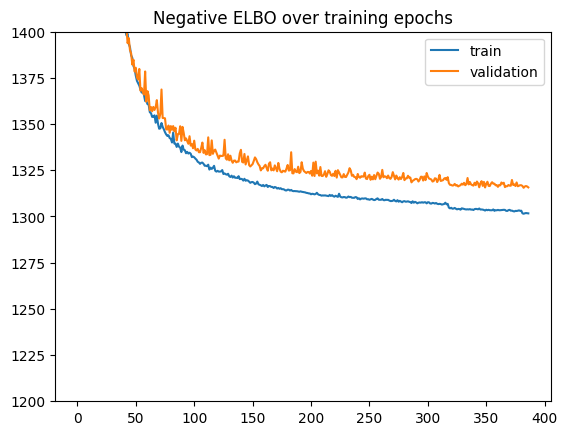

In [17]:
plt.plot(vae.history["elbo_train"], label="train")
plt.plot(vae.history["elbo_validation"], label="validation")
plt.title("Negative ELBO over training epochs")
plt.ylim(1200, 1400)
plt.legend()

In [18]:
adata.obsm["X_totalVI"] = vae.get_latent_representation()

rna, protein = vae.get_normalized_expression(
    n_samples=25,
    return_mean=True,
   # sample_protein_mixing=True,
     # protein_list = [1,2],
    scale_protein=True,
    transform_batch=["22", "23"]
)

adata.layers["denoised_rna"], adata.obsm["denoised_protein"] = rna, protein

adata.obsm["protein_foreground_prob"] = vae.get_protein_foreground_probability(
    n_samples=25,
    return_mean=True,
    transform_batch=["22", "23"]
)


In [19]:
#parsed_protein_names = [p.split("_")[0] for p in adata.obsm["protein_expression"].columns]
parsed_protein_names = [p for p in adata.obsm["protein_expression"].columns]
adata.obsm["protein_foreground_prob"].columns = parsed_protein_names

In [20]:
sc.pp.neighbors(adata, use_rep="X_totalVI")
sc.tl.umap(adata, min_dist=0.4)
sc.tl.leiden(adata, key_added="leiden_totalVI")

/scratch/derek/ipykernel_2972457/1819295610.py:3: FutureWarning: In the future, the default backend for leiden will be igraph instead of leidenalg.

 To achieve the future defaults please pass: flavor="igraph" and n_iterations=2.  directed must also be False to work with igraph's implementation.
  sc.tl.leiden(adata, key_added="leiden_totalVI")


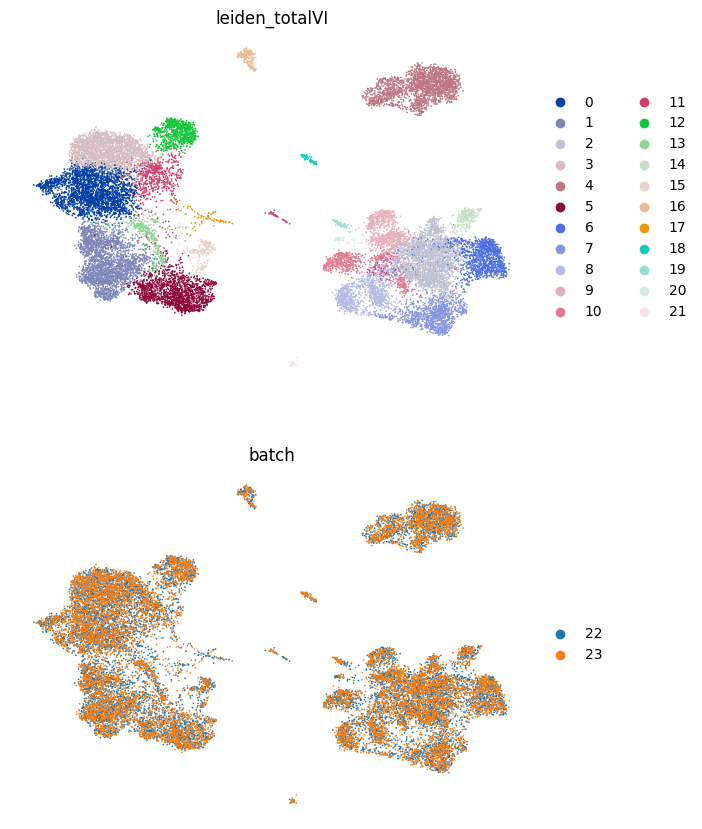

In [21]:
sc.pl.umap(
    adata,
    color=["leiden_totalVI", "batch"],
    frameon=False,
    ncols=1,
)

In [22]:
pro_adata = sc.AnnData(adata.obsm["protein_expression"].copy(), obs=adata.obs)
sc.pp.log1p(pro_adata)
# Keep log normalized data in raw
pro_adata.raw = pro_adata
pro_adata.X = adata.obsm["denoised_protein"]
# these are cleaner protein names -- "_TotalSeqB" removed


In [23]:
parsed_protein_names

['CD80_p',
 'CD274_p',
 'PDCD1LG2_p',
 'ICOSLG_p',
 'TNFRSF14_p',
 'TNFSF4_p',
 'CD137L_p',
 'PVR_p',
 'PVRL2_p',
 'CD47_p',
 'CD70_p',
 'TNFRSF8_p',
 'CD40_p',
 'CD40LG_p',
 'CD52_p',
 'CD3_p',
 'CD8_p',
 'NCAM1_p',
 'PTPRC_p',
 'CD19_p',
 'CD33_p',
 'CD34_p',
 'SDC1_p',
 'TNFRSF17_p',
 'B2M_p',
 'HLA-A_p',
 'THY1_p',
 'KIT_p',
 'MME_p',
 'CD45RA_p',
 'IL3RA_p',
 'CD7_p',
 'ITGA6_p',
 'CCR4_p',
 'CD4_p',
 'CD8A_p',
 'CD14_p',
 'CD16_p',
 'IL2RA_p',
 'CD45RO_p',
 'PDCD1_p',
 'TIGIT_p',
 'MS4A1_p',
 'NCR1_p',
 'PTGDR2_p',
 'EPCAM_p',
 'PECAM1_p',
 'CD44_p',
 'Podoplanin_p',
 'PDGFRB_p',
 'MCAM_p',
 'CDH1_p',
 'IgM_p',
 'CD5_p',
 'TCR_gd_p',
 'CCR5_p',
 'FCGR2A_p',
 'CCR6_p',
 'BLR1_p',
 'ITGAE_p',
 'CD69_p',
 'SELL_p',
 'KLRB1_p',
 'CTLA4_p',
 'LAG3_p',
 'KLRG1_p',
 'CD27_p',
 'LAMP1_p',
 'TNFRSF6_p',
 'TNFRSF4_p',
 'HLA-DR_p',
 'CD1C_p',
 'ITGAM_p',
 'FCGR1A_p',
 'THBD_p',
 'CD1D_p',
 'KLRK1_p',
 'CEACAM8_p',
 'C3BR_p',
 '[Not_p',
 'HAVCR2_p',
 'BTLA_p',
 'ICOS_p',
 'CD58_p',
 'CD96_p'

In [24]:
pro_adata.var["protein_names"] = parsed_protein_names
pro_adata.obsm["X_umap"] = adata.obsm["X_umap"]
pro_adata.obsm["X_totalVI"] = adata.obsm["X_totalVI"]

In [25]:
names = adata.obsm["protein_foreground_prob"].columns
for p in names:
    pro_adata.obs["{}_fore_prob".format(p)] = adata.obsm["protein_foreground_prob"].loc[:, p]

/scratch/derek/ipykernel_2972457/3864761437.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pro_adata.obs["{}_fore_prob".format(p)] = adata.obsm["protein_foreground_prob"].loc[:, p]
/scratch/derek/ipykernel_2972457/3864761437.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many times, which has poor performance.  Consider joining all columns at once using pd.concat(axis=1) instead. To get a de-fragmented frame, use `newframe = frame.copy()`
  pro_adata.obs["{}_fore_prob".format(p)] = adata.obsm["protein_foreground_prob"].loc[:, p]
/scratch/derek/ipykernel_2972457/3864761437.py:3: PerformanceWarning: DataFrame is highly fragmented.  This is usually the result of calling `frame.insert` many t

In [26]:
adata_ = sc.read_h5ad(input_dir+'gene_expression_v2.h5ad')

In [27]:
pro_adata.obs_names = adata.obs_names.str.replace(pat='-1-22', repl='-0').str.replace(pat='-1-23', repl='-1')

In [28]:
pro_adata_ = pro_adata[adata_.obs_names]

In [29]:
pro_adata_.obsm['X_umap'] = adata_.obsm['X_umap']

/scratch/derek/ipykernel_2972457/2185164297.py:1: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  pro_adata_.obsm['X_umap'] = adata_.obsm['X_umap']


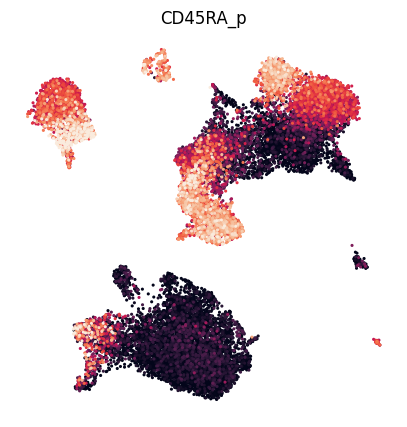

In [30]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

sc.pl.umap(
    pro_adata_,
    color=['CD45RA_p'],
    gene_symbols="protein_names",
    ncols=3,
    vmax="p99",
    use_raw=False,
    frameon=False,
    wspace=0.1,
    cmap='rocket',
    s=20,
    sort_order=True,
    vmin=0.0012,
    colorbar_loc = None,
    ax=ax,
    save='save=UMAP_CD45RA_cite.pdf'
)

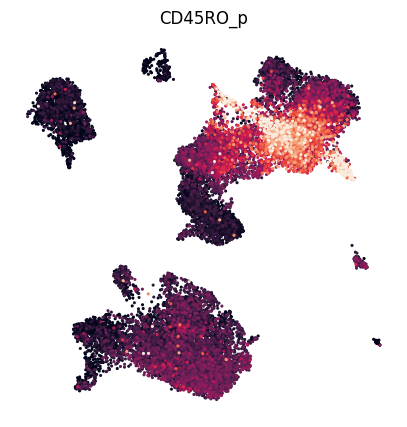

In [31]:
fig, ax = plt.subplots(1,1,figsize=(5,5))

sc.pl.umap(
    pro_adata_,
    color=['CD45RO_p'],
    gene_symbols="protein_names",
    ncols=3,
    vmax="p99",
    use_raw=False,
    frameon=False,
    wspace=0.1,
    cmap='rocket',
    s=20,
    sort_order=True,
    vmin=0.0012,
    colorbar_loc = None,
    ax=ax,
    save='save=UMAP_CD45RO_cite.pdf'
)

In [32]:
adata_spl = sc.read_h5ad(input_dir+'adata_spl_v2.h5ad')

adata_spl.obs_names = adata_spl.obs_names.str.replace(pat='-0-22',repl='-0').str.replace(pat='-1-23',repl='-1')

In [59]:
adata_spl = adata_spl[pro_adata_.obs_names]

adata_spl.obsm['X_umap'] = pro_adata_.obsm['X_umap'].copy()

/scratch/derek/ipykernel_2972457/3774184439.py:3: ImplicitModificationWarning: Setting element `.obsm['X_umap']` of view, initializing view as actual.
  adata_spl.obsm['X_umap'] = pro_adata_.obsm['X_umap'].copy()


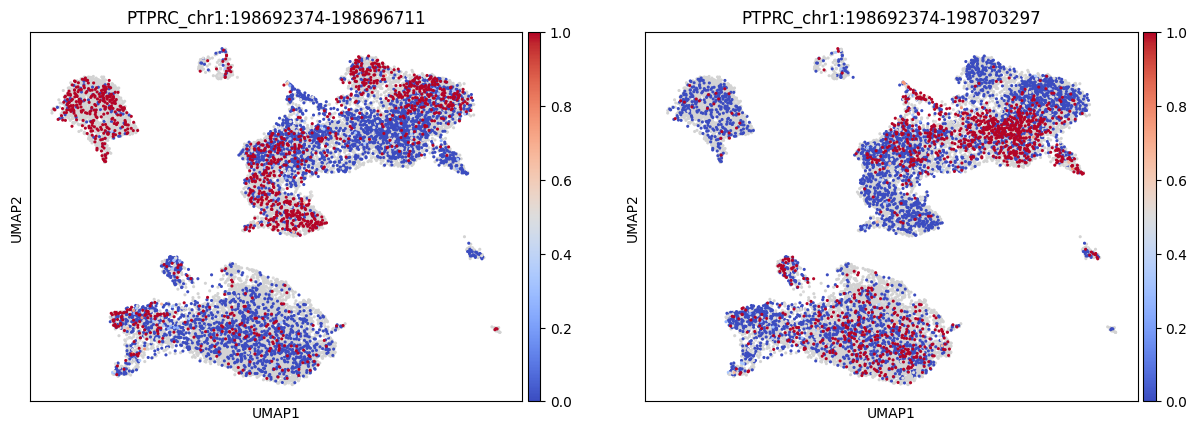

In [64]:
sc.pl.umap(adata_spl, 
           color=['PTPRC_chr1:198692374-198696711', #RO
                  'PTPRC_chr1:198692374-198703297'  #RA
                  ],
           layer='PSI_raw',
           cmap='coolwarm',
           ncols=2,
           size=20 ,
          )

In [84]:
df = pro_adata_.to_df()[['CD45RA_p','CD45RO_p']].join(
    adata_spl.to_df(layer='PSI_raw')['PTPRC_chr1:198692374-198696711']).join(
    adata_spl.to_df(layer='PSI_raw')['PTPRC_chr1:198692374-198703297'])


df = df.join(adata_spl.obs.ct1)


In [86]:
df

,CD45RA_p,CD45RO_p,PTPRC_chr1:198692374-198696711,PTPRC_chr1:198692374-198703297,ct1
barcode_index,,,,,
AAACCTGAGATATGCA-0,0.000218,0.001602,0.0,1.0,cM
AAACCTGAGCTGATAA-0,0.000031,0.001463,NaN,NaN,cM
AAACCTGAGGTCGGAT-0,0.000071,0.002143,NaN,NaN,T4
AAACCTGAGTACGTTC-0,0.001342,0.001794,NaN,NaN,T4
AAACCTGAGTCAAGCG-0,0.001944,0.002082,0.0,1.0,T4
...,...,...,...,...,...
TTTGTCAGTGTTGAGG-1,0.002452,0.001640,NaN,NaN,T4
TTTGTCAGTTGGACCC-1,0.001313,0.000748,NaN,NaN,ncM
TTTGTCAGTTGTACAC-1,0.010090,0.001234,NaN,NaN,T8


In [147]:
temp = df[df.ct1=='T8']

In [148]:
temp_ = temp[~temp['PTPRC_chr1:198692374-198696711'].isna()]

In [149]:
temp_

,CD45RA_p,CD45RO_p,PTPRC_chr1:198692374-198696711,PTPRC_chr1:198692374-198703297,ct1
barcode_index,,,,,
AAACGGGAGTCGCCGT-0,0.005590,0.001338,0.0,0.0,T8
AAAGCAAAGGTAAACT-0,0.002333,0.001651,0.0,0.0,T8
AAAGCAAGTATGGTTC-0,0.001009,0.001742,0.0,1.0,T8
AACACGTTCACTTACT-0,0.003378,0.001592,0.0,0.5,T8
AACCATGTCAGCATGT-0,0.003865,0.001411,0.0,0.0,T8
...,...,...,...,...,...
TTTATGCAGCGTAGTG-1,0.011596,0.001030,0.0,0.0,T8
TTTATGCCACCGGAAA-1,0.001064,0.001882,0.0,0.0,T8
TTTATGCTCACAACGT-1,0.000404,0.001946,0.0,0.0,T8


In [136]:
from sklearn.preprocessing import MinMaxScaler

In [138]:
scaler = MinMaxScaler(feature_range=(0, 1))

In [150]:
temp_['CD45RO_p_scaled'] = scaler.fit_transform(temp_['CD45RO_p'].values[:, None])
temp_['CD45RA_p_scaled'] = scaler.fit_transform(temp_['CD45RA_p'].values[:, None])


/scratch/derek/ipykernel_2972457/3929057212.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_['CD45RO_p_scaled'] = scaler.fit_transform(temp_['CD45RO_p'].values[:, None])
/scratch/derek/ipykernel_2972457/3929057212.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  temp_['CD45RA_p_scaled'] = scaler.fit_transform(temp_['CD45RA_p'].values[:, None])


<Axes: xlabel='CD45RA_p_scaled', ylabel='PTPRC_chr1:198692374-198696711'>

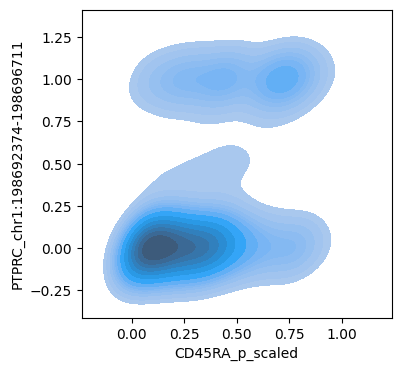

In [156]:
fig, ax = plt.subplots(1,1, figsize = (4,4))

sns.kdeplot(temp_,
            x='CD45RA_p_scaled',
            y='PTPRC_chr1:198692374-198696711',
           # hue=df_['ct2'],
            fill=True,
            cut=3,
        levels=15,
        thresh=.1,
   # common_norm=False
            ax=ax
               )
#ax.set(xlim = (0, 0))

In [40]:
!conda list

/c4/home/derek/miniconda3/envs/SCVI/lib/python3.9/pty.py:85: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid, fd = os.forkpty()


# packages in environment at /c4/home/derek/miniconda3/envs/SCVI:
#
# Name                    Version                   Build  Channel
_libgcc_mutex             0.1                 conda_forge    conda-forge
_openmp_mutex             4.5                       2_gnu    conda-forge
absl-py                   2.1.0                    pypi_0    pypi
aiohttp                   3.9.5                    pypi_0    pypi
aiosignal                 1.3.1                    pypi_0    pypi
anndata                   0.10.7                   pypi_0    pypi
anyio                     4.3.0              pyhd8ed1ab_0    conda-forge
archspec                  0.2.3              pyhd8ed1ab_0    conda-forge
argon2-cffi               23.1.0             pyhd8ed1ab_0    conda-forge
argon2-cffi-bindings      21.2.0           py39hd1e30aa_4    conda-forge
array-api-compat          1.7                      pypi_0    pypi
arrow                     1.3.0              pyhd8ed1ab_0    conda-forge
asttokens               